<h2>KNN Model<h2>

In [39]:
#import packages

import sys
print(sys.executable)

import skimage
print(skimage.__version__)

import os
import cv2

#from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops


c:\Users\xfaan\Documents\GitHub\is460-project\myenv\Scripts\python.exe
0.22.0


<h2> Data Pre-processing <h2>

In [23]:
# Load and Preprocess Data
DATA_SPLIT = 'train' 
DATA_DIR = os.path.join("chest_xray", DATA_SPLIT)
CATEGORIES = ["NORMAL", "PNEUMONIA"]

data = []

labels = []

for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_array = cv2.resize(img_array, (150, 150))
        data.append(resized_array)
        labels.append(category)


Texture-based Feature Extraction

In [24]:
# Texture-based Feature Extraction

def compute_texture_features(image):
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

# Extract texture features
texture_features = [compute_texture_features(image) for image in data]


Dimensionality Reduction using PCA

In [25]:
# Dimensionality Reduction using PCA - Flatten the data and apply PCA

data_flat = [img.flatten() for img in data]
data_combined = [np.hstack((data_flat[i], texture_features[i])) for i in range(len(data_flat))]

pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_combined)


Data Augmentation

In [34]:
# Data Augmentation
augment = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

augmented_data = []
augmented_labels = []

for image, label in zip(data, labels):
    image = image.reshape(1, 150, 150, 1)
    for x_batch in augment.flow(image, batch_size=1):
        augmented_data.append(x_batch.reshape(150, 150))
        augmented_labels.append(label)
        if len(augmented_data) % 5 == 0:  # for example, generate 5 augmented versions per image
            break


<h2>Training KNN Model<h2>

In [35]:
# Train KNN Model and find the best k value

from sklearn.model_selection import train_test_split

X = np.array(augmented_data).reshape(-1, 150*150)
y = np.array(augmented_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Finding the best k
accuracy_list = []
for k in range(1, 21):  # checking k from 1 to 20
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy_list.append(knn.score(X_test, y_test))

best_k = accuracy_list.index(max(accuracy_list)) + 1


<h2> Metrics <h2>

In [36]:
# Metrics

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.69      0.77      1356
   PNEUMONIA       0.90      0.96      0.93      3860

    accuracy                           0.89      5216
   macro avg       0.89      0.83      0.85      5216
weighted avg       0.89      0.89      0.89      5216


Confusion Matrix:
[[ 941  415]
 [ 139 3721]]


Classification Report:

Precision: Out of all the predictions made by the model for each class, how many were correct.
For "NORMAL", the precision is 0.87. This means that 87% of the images predicted as "NORMAL" were actually "NORMAL".
For "PNEUMONIA", the precision is 0.90. This means that 90% of the images predicted as "PNEUMONIA" were truly "PNEUMONIA".
Recall: Out of all the actual instances of each class, how many were correctly predicted by the model.
For "NORMAL", the recall is 0.69. This means that the model correctly identified 69% of all the actual "NORMAL" instances.
For "PNEUMONIA", the recall is 0.96. This indicates the model identified 96% of all the actual "PNEUMONIA" instances.
F1-score: Harmonic mean of precision and recall. A higher F1-score indicates better performance.
The model performs slightly better for "PNEUMONIA" (F1 of 0.93) than for "NORMAL" (F1 of 0.77).
The weighted average metrics give an idea of the overall performance, accounting for the distribution of the classes. The model has a general accuracy of 0.89, meaning it predicts the correct class 89% of the time.


Confusion Matrix:

There are more true positives for "PNEUMONIA" (3721) than true negatives for "NORMAL" (941).
The model has made some misclassifications (415 images with pneumonia are predicted as normal and 139 normal images are predicted as pneumonia).
K vs. Accuracy Graph:

<h2>K vs. Accuracy Graph:<h2>

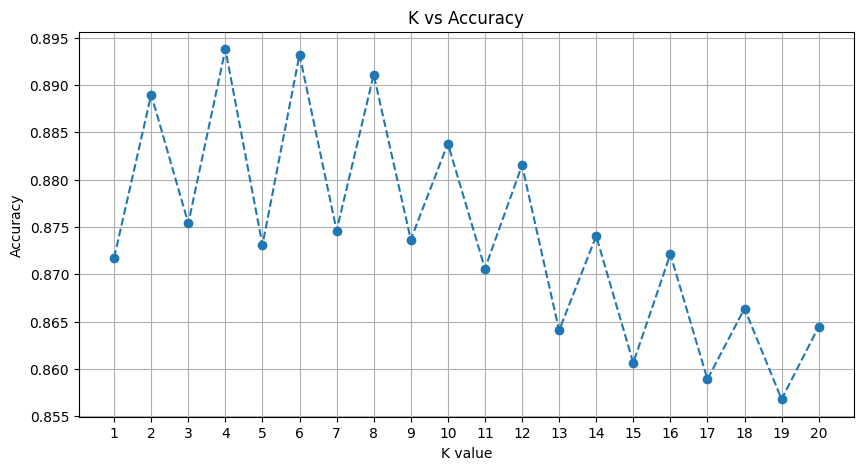

In [37]:
# Visualizing the accuracy for different values of k
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), accuracy_list, marker='o', linestyle='dashed')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()


K vs. Accuracy Graph:

- This graph shows how the model's accuracy changes for different values of k (number of neighbors).
- The accuracy fluctuates, with some peaks and troughs.
- No clear trend (increasing or decreasing) is observed, which suggests that the data might not be uniformly distributed in the feature space, or there might be overlapping regions between the classes.
- Odd values of k seem to perform slightly better than even values.
- choose a value of k around 5 or 7 where the accuracy is relatively high and stable compared to higher values of k.


Model Performance: 
- The KNN model performs quite well, especially in detecting pneumonia cases. 
- However, the slightly lower recall for the "NORMAL" class might indicate some false negatives, which in a medical diagnosis scenario, might be risky. 
- We'd ideally want both high sensitivity (high recall for "PNEUMONIA") and high specificity (high recall for "NORMAL").

Choice of k: 
- The graph helps in identifying the optimal number of neighbors (k) to use. 
- It suggests that increasing k doesn't always lead to better performance, and there's a trade-off between computational cost and accuracy.

Further Steps: 
- consider other algorithms or even ensemble methods to improve the recall for the "NORMAL" class.


In conclusion, while the model performs reasonably well, especially in detecting pneumonia, it's essential to be cautious with medical diagnoses. 